In [1]:
# paraPropPython time-dependent signal example use of paraPropPython.py notebook
# s. prohira, c. sbrocco
import sys
sys.path.append('../')
%matplotlib inline
import paraPropPython as ppp
from receiver import receiver
import numpy as np
import matplotlib.pyplot as plt
import util as util
import time

In [2]:
#### time-dependent example #####

### first, initialize an instance of paraProp by defining its dimensions and frequency of interest ###
iceDepth = 1000. # m
iceLength = 110. # m
dx = 1 # m
dz = 0.01 # m

freq = 0.2

### it is useful to set the reference depth as the source depth when you only have one transmitter ###
sourceDepth = 10. # m
sim = ppp.paraProp(iceLength, iceDepth, dx, dz, refDepth=1, airHeight=1)

### useful arrays for plottinng ###
z = sim.get_z()
x = sim.get_x()

In [3]:
### NOTE: define n before defining source ###
def get_profile_from_file(fname):
    profile_data = np.genfromtxt(fname)
    z_profile = profile_data[:,0]
    n_profile = profile_data[:,1]
    return n_profile, z_profile

### an example of defining n as a function of z (also can be done using a vector, see implementation) ###
rho_vec0, z_vec0 = get_profile_from_file('NP_data_dzb.txt')
rho_vec0 = rho_vec0/1e3

A0 = 1.0
B0 = 0.841
def rho2refindex(rho, A, B):
    return A + B * rho



In [4]:
#Simulation Geometry
iceDepth = 60. # m
iceLength = 110. # m
dx = 1 # m
dz = 0.05 # m

#Frequency
freq = 0.2

#Tx and Rx
sourceDepth0 = 10. # m
sourceDepth1 = 20. # m
sourceDepth2 = 50. # m
receiverL0 = 30.
receiverL1 = 100.
receiverDepth0 = 10.
receiverDepth1 = 20.
receiverDepth2 = 50.
receiverRange = [receiverL0, receiverL1]
sourceDepth= [sourceDepth0,sourceDepth1,sourceDepth2]
receiverDepth = [receiverDepth0,receiverDepth1,receiverDepth2]
#Signal Properties
### set a td signal ###

#Refractive Index
### NOTE: define n before defining source ###
def get_profile_from_file(fname):
    profile_data = np.genfromtxt(fname)
    z_profile = profile_data[:,0]
    n_profile = profile_data[:,1]
    return n_profile, z_profile


def get_rx_pulse(z_vec, n_vec, z_tx=sourceDepth, x_rx=receiverRange, z_rx=receiverDepth):
    dt = 1
    impulse = np.zeros(2**8, dtype='complex')
    impulse[10] = 1+0j
    sig = util.normToMax(util.butterBandpassFilter(impulse, 0.09, 0.25, 1/dt, 4))

    sim = ppp.paraProp(iceLength, iceDepth, dx, dz, refDepth=1, airHeight=1)
    sim.set_n(nVec=n_vec, zVec=z_vec)
    sim.set_dipole_source_profile(freq, z_tx)
    sim.set_td_source_signal(sig, dt)
    rxList = [receiver(x_rx, z_rx)]
    ### run the solver ###
    sim.do_solver(rxList)
    rx = rxList[0]
    t = rx.get_time()
    sig_rx = rx.get_signal().real
    f = rx.get_frequency()
    spec_rx = rx.get_spectrum()
    return sig_rx, t, spec_rx, f
def rho2refindex(rho, A, B):
    return A + B * rho

In [5]:
def findNearest(x_arr, x):
    ii = np.argmin(abs(x_arr-x))
    return ii

def double_exp(z, rho_s, k1, k2):
    rho_i = 0.918
    rho_1 = 0.55
    rho_out_1 = rho_i + (rho_s-rho_i)*np.exp(-k1*z)
    ii_1 = findNearest(rho_out_1, rho_1)

    rho_1_approx = rho_out_1[ii_1]
    z1_approx = z[ii_1]
    rho_out_2 = rho_i + (rho_1_approx-rho_i)*np.exp(-k2*(z-z1_approx))

    nDepths = len(z)

    rho_out = np.zeros(nDepths)
    rho_out[:ii_1] = rho_out_1[:ii_1]
    rho_out[ii_1:] = rho_out_2[ii_1:]
    return rho_out

In [6]:
import numpy as np
from scipy.optimize import curve_fit

# Define the functions to compute refractive indices
def cubedn(rho, A, B):
    return np.sqrt((A + B * rho) ** 3)

def rho2refindex(rho, A, B):
    return A + B * rho

# Parameters
A1, A2, A3 = 1.0, 0.988, 0.992
B1, B2, B3, B4, B5 = 0.840, 0.845, 0.850, 0.848, 0.508

# Assume these functions are defined to get data from a file
rho_vec0, z_vec0 = get_profile_from_file('NP_data_dzb.txt')
rho_vec0 = rho_vec0 / 1e3  # Convert units if necessary

# Define ice depth and step size
iceDepth = 1000  # Maximum depth in meters
dz = 0.01        # Depth step size in meters

# Generate depth values
z_vec = np.arange(0, iceDepth, dz)
rho_vec = np.interp(z_vec, z_vec0, rho_vec0)  # Interpolate density profile

# Generate refractive indices for each model
n_vec_list = [
    rho2refindex(rho_vec, A1, B1),
    rho2refindex(rho_vec, A1, B2),
    rho2refindex(rho_vec, A2, B2),
    rho2refindex(rho_vec, A3, B4),
    rho2refindex(rho_vec, A2, B3),
    cubedn(rho_vec, A1, B5)
]
B_list = [B1, B2, B2, B4, B3, B5]
A_list = [A1, A1, A2, A3, A2, A1]

# Define an asymptotic exponential function with a fixed asymptote at 1.78
def asymptotic_exp_fixed(depth, a, b):
    return a * np.exp(-b * depth) + 1.78  # c is fixed at 1.78

'''    
fig = plt.figure(figsize=(10,6),dpi=100)
ax = fig.add_subplot(111)

N1 = 1
#N1 = len(n_vec_list)
for i in range(N1):
    n_vec = n_vec_list[i]
    # Fit the refractive index values across all depths with the fixed asymptote
    popt,pcov  = curve_fit(asymptotic_exp_fixed, z_vec, n_vec, p0=(-0.5, 0.01))
    a, b = popt
    print(a,b)
    # Generate the adjusted refractive index values using the fitted function
    n_vec_adjusted = asymptotic_exp_fixed(z_vec, a, b)
    
    ax.plot(z_vec,  n_vec_adjusted,label=str(a) + ' ' + str(b))
    ax.plot(z_vec,n_vec_list[1])   
ax.legend()
ax.set_xlim(0, 80)
plt.show()
'''

"    \nfig = plt.figure(figsize=(10,6),dpi=100)\nax = fig.add_subplot(111)\n\nN1 = 1\n#N1 = len(n_vec_list)\nfor i in range(N1):\n    n_vec = n_vec_list[i]\n    # Fit the refractive index values across all depths with the fixed asymptote\n    popt,pcov  = curve_fit(asymptotic_exp_fixed, z_vec, n_vec, p0=(-0.5, 0.01))\n    a, b = popt\n    print(a,b)\n    # Generate the adjusted refractive index values using the fitted function\n    n_vec_adjusted = asymptotic_exp_fixed(z_vec, a, b)\n    \n    ax.plot(z_vec,  n_vec_adjusted,label=str(a) + ' ' + str(b))\n    ax.plot(z_vec,n_vec_list[1])   \nax.legend()\nax.set_xlim(0, 80)\nplt.show()\n"

-0.47605007073509903 0.02234672024950224
-0.4750393503847285 0.02276128984937356
-0.48502476977941494 0.021719061717112766
-0.4810587276398567 0.0222968855106608
-0.48397607141891225 0.0221124622095699
-0.4934673319538794 0.021984023315565596


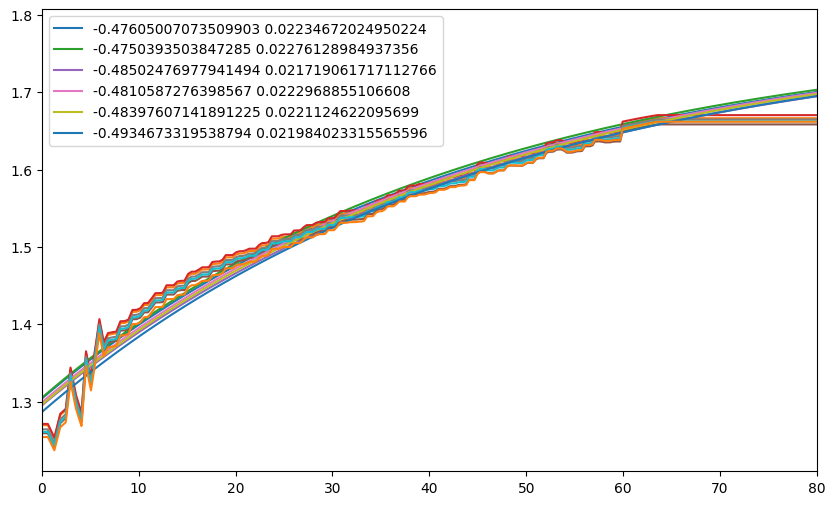

In [8]:
extrap_pnt=findNearest(z_vec, 60)
fig = plt.figure(figsize=(10,6),dpi=100)
ax = fig.add_subplot(111)

N1 = len(n_vec_list)
for i in range(N1):
    n_vec = n_vec_list[i]
    z_vec_cut = z_vec[:extrap_pnt]
    n_vec_cut = n_vec[:extrap_pnt]
    # Fit the refractive index values across all depths with the fixed asymptote
    popt,pcov  = curve_fit(asymptotic_exp_fixed, z_vec_cut, n_vec_cut, p0=(-0.5, 0.01))
    a, b = popt
    print(a,b)
    # Generate the adjusted refractive index values using the fitted function
    n_vec_adjusted = asymptotic_exp_fixed(z_vec, a, b)
    
    ax.plot(z_vec,  n_vec_adjusted,label=str(a) + ' ' + str(b))
    ax.plot(z_vec,n_vec_list[i])   
ax.legend()
ax.set_xlim(0, 80)
plt.show()

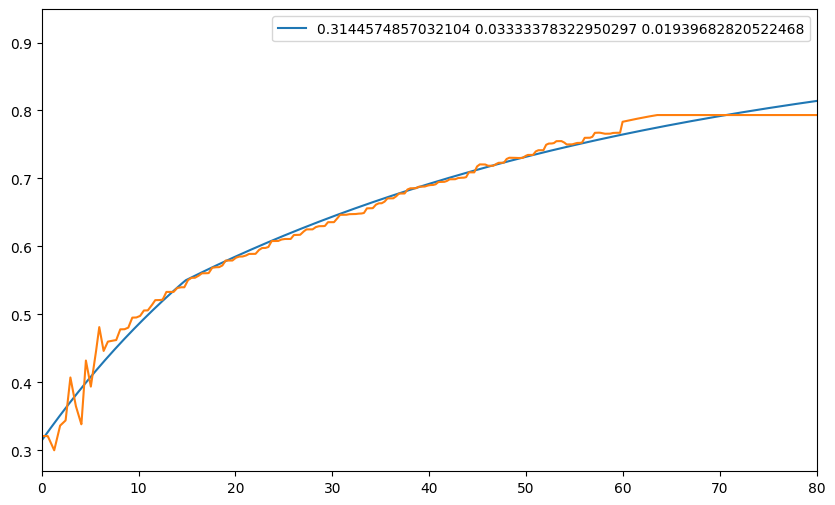

"\nN1 = len(n_vec_list)\nfor i in range(N1):\n    n_vec = n_vec_list[i]\n    z_vec_cut = z_vec[:extrap_pnt]\n    n_vec_cut = n_vec[:extrap_pnt]\n    # Fit the refractive index values across all depths with the fixed asymptote\n    popt,pcov  = curve_fit(double_exp, z_vec_cut, n_vec_cut, p0=(-0.5, 0.01))\n    a, b = popt\n    print(a,b)\n    # Generate the adjusted refractive index values using the fitted function\n    n_vec_adjusted = asymptotic_exp_fixed(z_vec, a, b)\n    \n    ax.plot(z_vec,  n_vec_adjusted,label=str(a) + ' ' + str(b))\n    ax.plot(z_vec,n_vec_list[i])   \nax.legend()\nax.set_xlim(0, 80)\nplt.show()\n"

In [10]:
extrap_pnt=findNearest(z_vec, 60)

rho_vec_cut = rho_vec[:extrap_pnt]
popt, pcov = curve_fit(double_exp, z_vec_cut,rho_vec_cut, p0=(0.3,0.01,0.01))
a,b,c = popt
rho_vec_adjusted = double_exp(z_vec, a,b,c)


fig = plt.figure(figsize=(10,6),dpi=100)
ax = fig.add_subplot(111)
ax.plot(z_vec, rho_vec_adjusted, label=str(a) + ' ' + str(b) + ' ' + str(c))
ax.plot(z_vec,rho_vec)
ax.legend()
ax.set_xlim(0,80)

plt.show()


'''
N1 = len(n_vec_list)
for i in range(N1):
    n_vec = n_vec_list[i]
    z_vec_cut = z_vec[:extrap_pnt]
    n_vec_cut = n_vec[:extrap_pnt]
    # Fit the refractive index values across all depths with the fixed asymptote
    popt,pcov  = curve_fit(double_exp, z_vec_cut, n_vec_cut, p0=(-0.5, 0.01))
    a, b = popt
    print(a,b)
    # Generate the adjusted refractive index values using the fitted function
    n_vec_adjusted = asymptotic_exp_fixed(z_vec, a, b)
    
    ax.plot(z_vec,  n_vec_adjusted,label=str(a) + ' ' + str(b))
    ax.plot(z_vec,n_vec_list[i])   
ax.legend()
ax.set_xlim(0, 80)
plt.show()
'''

In [11]:
N = len(z_vec)
rho_vec_output = np.zeros(N)
rho_vec_output[:extrap_pnt] = rho_vec[:extrap_pnt]
rho_vec_output[extrap_pnt:] = rho_vec_adjusted[extrap_pnt:]

# Generate refractive indices for each model
n_vec_list_true = [
    rho2refindex(rho_vec_output, A1, B1),
    rho2refindex(rho_vec_output, A1, B2),
    rho2refindex(rho_vec_output, A2, B2),
    rho2refindex(rho_vec_output, A3, B4),
    rho2refindex(rho_vec_output, A2, B3),
    cubedn(rho_vec_output, A1, B5)
]


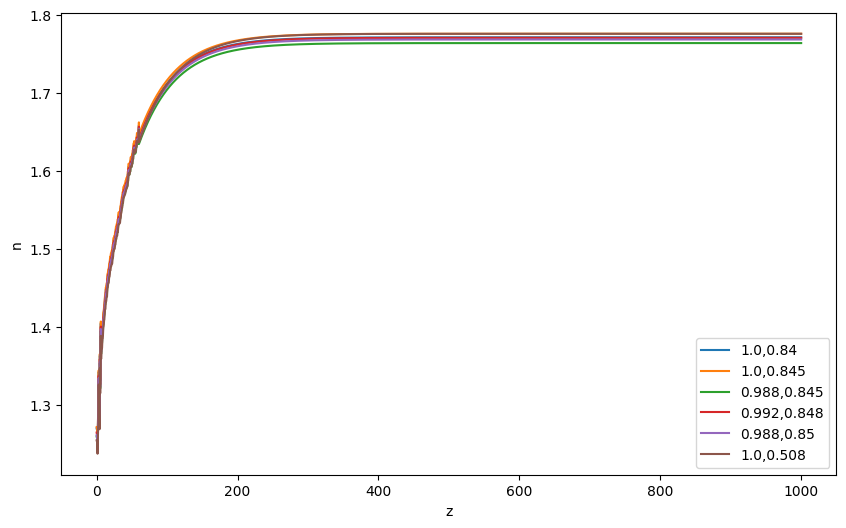

In [20]:
fig = plt.figure(figsize=(10,6),dpi=100)
ax = fig.add_subplot(111)
for i in range(len(n_vec_list_true)):
    ax.plot(z_vec, n_vec_list_true[i], label = str(A_list[i]) + "," + str(B_list[i]))
ax.legend()
ax.set_xlabel('z')
ax.set_ylabel('n')
ax.figure.savefig("Split_exponential_fits")

In [28]:


# Process each refractive index model
for i, n_vec in enumerate(n_vec_list_true):
    
    # Save the adjusted refractive index values to a file
    filename = f"Actual_refractive_index_model_{i + 1}.txt"
    with open(filename, "w") as f:
        np.savetxt(f, np.column_stack((z_vec, n_vec_list_true[i])), fmt="%.4f")

print("Text files with fixed asymptotic value generated successfully.")


Text files with fixed asymptotic value generated successfully.


In [ ]:
#check fit by plotting up to 60 m and 1000 m
#input the split exponential function
#output data files will have actual data up to 60 m and then acutal fit after 60 m
#find the neem, and other ice density files and put into GIthub 

#go to the cluster, input refractive index files inot firn-varaince 2 directory, change config_askaryan01 to read the index of refraction files
#run runSim_ascan_rx_from_txt
